## Семинар 1 "Полносвязные нейронные сети"

ФИО: Козлов Иван Сергеевич

В этом задании вам предстоит реализовать проход "вперед" для полносвязной нейронную сети. В дальнейшем мы реализуем процедуру обучения и научим сеть распознавать рукописные цифры.

На первой лекции мы познакомились с тем, что такое нейронные сети и изучили три слоя — линейный, сигмоида и SoftMax. Из этих слоев можно составлять глубокие архитектуры и обучать их при помощи градиентного спуска. Чтобы конструировать сложные архитектуры, можно реализовать каждый тип слоя как отдельный "кирпичик" и затем собирать полную архитектуру как конструктор. Это мы и попробуем сделать на первом и втором семинарах.

Каждый тип слоя мы будем реализовывать при помощи класса, который будет поддерживать три функции: forward, которая будет применять функцию, реализуемую слоем, к входной матрице и backward, которая будет вычислять градиенты и step, которая будет обновлять веса. Чтобы не применять функцию к каждому объекту в отдельности, мы будем подавать на вход слою матрицу размера (N, d), где N — количество объектов, а d — размерность каждого объекта.

<img src=backprop.pdf width=400>

Функция forward будет вычислять по $x$ значение $y$, backward — по $\frac{\partial L}{\partial y}$ вычислять $\frac{\partial L}{\partial x}$ и обновлять внутри себя $\frac{\partial L}{\partial w}$.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

### Часть 1: Линейный слой


In [2]:
class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        #### Create weights, initialize them with samples from N(0, 0.1).
        self.input_size = input_size
        self.output_size = output_size
        self.w = np.random.normal(0, 0.1, (self.input_size, self.output_size))
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        #### Apply layer to input
        self.X = X.copy()
        self.X_intercept = np.c_[X, np.ones(X.shape[0])]
        return np.dot(self.X, self.w)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        self.dLdw = np.dot(self.X.T, dLdy)
        return np.dot(dLdy, self.w.T)
    
    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - l*dLdw
        '''
        self.w -= learning_rate * self.dLdw

### Часть 2: Сигмоида

In [3]:
class Sigmoid:
    def __init__(self):
        pass
    
    def _sigmoid(self, x):
        return 1.0/(1 + np.exp(-x))
    
    def _derivative_sigmoid(self, x):
        return np.exp(-x) * (self._sigmoid(x)**2)
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        #### Apply layer to input
        self.X = X.copy()
        return self._sigmoid(X)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return dLdy * self._derivative_sigmoid(self.X)
    
    def step(self, learning_rate):
        pass

### Часть 3: Функция потерь

Как мы увидели на семинаре, вычисление производной для связки SoftMax + Negative log-likelihood проще чем для этих двух слоев по отдельности. Поэтому мы реализуем их как один класс. Важное замечание: на проходе "вперед" важно воспользоваться трюком <a href="https://hips.seas.harvard.edu/blog/2013/01/09/computing-log-sum-exp/">log-sum-exp</a>, чтобы не столкнуться с численными неустойчивостями.

In [4]:
class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        #### YOUR CODE HERE
        #### (Hint: No code is expected here, just joking)
    
    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        y is np.array of size (N), contains correct labels
        '''
        #### Apply layer to input
        self.y = y.copy()
        self.p = np.divide(np.exp(X).T, np.exp(X).sum(axis=1)).T
        return self.p, -np.log(self.p[y == 1]).sum()
    
    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        dLdx = self.p.copy()
        dLdx[self.y == 1] -= 1
        return dLdx
    
    def step(self, learning_rate):
        pass

### Часть 4, нейронная сеть

Теперь, когда у нас есть "кирпичики", мы можем написать класс, который будет собирать всю сеть вместе 

In [5]:
class NeuralNetwork:
    def __init__(self, modules, loss_layer, epochs, learning_rate=0.01):
        '''
        Constructs network with *modules* as its layers
        '''
        self.modules = modules
        self.loss_layer = loss_layer
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.loss_arr = []
    
    def forward(self, X):
        #### Apply layers to input
        self.X = X.copy()
        for i, layer in enumerate(self.modules):
            self.X = self.modules[i].forward(self.X)
        return self.X
        
    
    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        self.dLdy = dLdy
        for layer in self.modules[::-1]:
            self.dLdy = layer.backward(self.dLdy)
            layer.step(self.learning_rate)
    
    def step(self, learning_rate):
        pass
    
    def fit(self, X, y):
        self.y = pd.get_dummies(pd.Series(y)).values
        for epoch in xrange(self.epochs):
            self.output = self.forward(X)
            self.output, loss = self.loss_layer.forward(self.output, self.y)
            self.loss_arr.append(loss.sum())
            dLdy = self.loss_layer.backward()
            self.backward(dLdy)
        return self
    
    def predict(self, X):
        return self.forward(X)

### Часть 5, обучение на простых данных

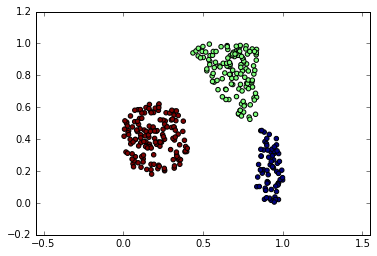

In [6]:
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

Обучите архитектуру вида 2 -> 10 -> 10 -> 3:
* Linear(2, 10)
* Sigmoid()
* Linear(10, 10)
* Sigmoid()
* Linear(10, 3)

В качестве функции потерь используйте NLLLoss.
1. Создайте сеть, в цикле запускайте forward, backward, step (используйте learning rate 0.01). 
2. Нарисуйте график сходимости (изменение NLL со временем).
3. Нарисуйте разделяющую поверхность

Отличная визуализация: http://playground.tensorflow.org/

In [7]:
plt.style.use('ggplot')

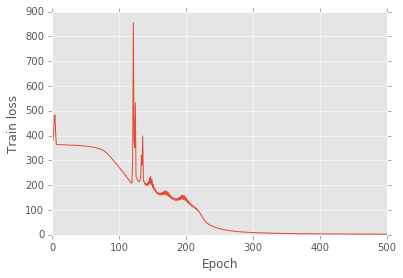

In [11]:
modules = [Linear(2, 10), Sigmoid(), Linear(10, 10), Sigmoid(), Linear(10, 3)]
loss_layer = NLLLoss()
nn = NeuralNetwork(modules, loss_layer, learning_rate=0.01, epochs=500).fit(X, y)

plt.plot(range(1, nn.epochs+1), nn.loss_arr)
plt.xlabel('Epoch')
plt.ylabel('Train loss')

In [12]:
nn.output

array([[  4.77160057e-11,   2.51711662e-04,   9.99748288e-01],
       [  5.98108326e-10,   1.31796992e-05,   9.99986820e-01],
       [  7.59511067e-12,   2.82425490e-06,   9.99997176e-01],
       ..., 
       [  2.85707539e-12,   3.14677203e-05,   9.99968532e-01],
       [  9.93695431e-01,   6.18637006e-03,   1.18199275e-04],
       [  1.10582038e-02,   9.86566407e-01,   2.37538917e-03]])

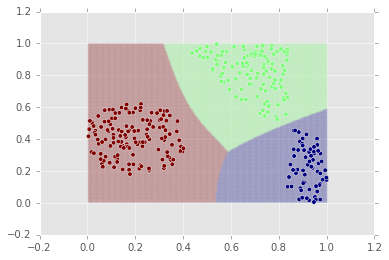

In [13]:
color_points = []
colors = []

for i in np.linspace(X[:,0].min(), X[:,0].max(), 200):
    for j in np.linspace(X[:,1].min(), X[:,1].max(), 200):
        color_points.append([i, j])
        colors.append(np.argmax(nn.forward(np.array([[i, j]])), axis=1)[0])  
color_points = np.array(color_points)
plt.scatter(color_points[:,0], color_points[:,1], c=colors, alpha=0.1, marker='.')
plt.scatter(X[:, 0], X[:, 1], c=y)